# Handling systems with long-range interactions

Systems with some degree of ionicity demand special attention when computing the phonon dispersion.
Specifically, they exhibit a splitting of the longitudinal optical (LO) and transverse optical (TO) branches in the long-wave length limit, i.e. small momentum vectors ($\vec{q}\rightarrow 0$).
When computing the phonon dispersion directly from the force constant matrix without further treatment, this splitting is missing.
A common approach for recovering the correct behavior is to apply a non-analytic correction (NAC) as discussed for example by Gonze and Lee ([Phys. Rev. B **55**, 10355 (1997)](https://doi.org/10.1103/PhysRevB.55.10355); a more comprehensive list of references can be found in the [phonopy documentation](https://phonopy.github.io/phonopy/formulation.html#non-analytical-term-correction)).
To apply this correction one requires knowledge of the Born effective charges $\mathcal{Z}_{i,\alpha\beta}^*$ as well as the electronic part of the static dielectric tensor $\epsilon_{\alpha\beta}^\infty$.

For the same fundamental reasons such systems often feature long-ranged ionic interactions, which can be difficult to capture using a short-ranged force constant potential (FCP), leading to erroneous behavior especially near the $\Gamma$-point.
To overcome this problem one can first substract the long-ranged contribution, then express the remaining ("chemical") part via a regular short-ranged FCP, and finally combine the two whenever computing forces for an arbitrary displacement pattern, be it for generating phonon dispersions, lifetimes or forces for molecular dynamics simulations.

This notebook illustrates the physical behavior outlined above and demonstrates the procedure by which the correct behavior in the long-wavelength limit can be restored.

To this end, we consider two prototypical ionic materials, NaCl and MgO, both of which adopt the rocksalt structure.
The code below can be run for either case by changing the value of the `material` variable to either `'NaCl'` or `'MgO'`.
All reference data needed for this example, including forces, Born effective charges and dielectric tensors, is contained in the [ASE database](https://wiki.fysik.dtu.dk/ase/ase/db/db.html) `reference-calculations.db`.

The following code snippet can be used to generate configurations for use with [phonopy](https://phonopy.github.io/phonopy/) as well as [rattled structures for use with hiphive](https://hiphive.materialsmodeling.org/moduleref/structures.html#preparing-structures-for-training).
The forces obtained via density functional theory calculations using the PBE functional as implemented in [VASP](https://www.vasp.at/) are already included in the database `reference-calculations.db`.

In [1]:
import numpy as np
from ase import Atoms
from ase.db import connect
from ase.io import write
from hiphive.structure_generation import generate_rattled_structures
from phonopy import Phonopy
from phonopy.structure.atoms import PhonopyAtoms

# helper functions repeatedly used below
def ase_to_phonopy(atoms: Atoms) -> PhonopyAtoms:
    """ Convert from ASE Atoms to PhonopyAtoms format. """
    return PhonopyAtoms(symbols=atoms.symbols, cell=atoms.cell,
                        scaled_positions=atoms.get_scaled_positions())


def phonopy_to_ase(phatoms: PhonopyAtoms) -> Atoms:
    """ Convert from PhonopyAtoms to ASE Atoms format. """
    return Atoms(phatoms.symbols, positions=phatoms.positions,
                 cell=phatoms.cell, pbc=True)

material = 'NaCl'
displ = 0.01  # displacement magnitude

# supercell geometry; this matrix generates a 3x3x3 repetition of the conventional (8-atom) cell
cell_repetition = 3 * np.array([[-1, 1, 1], [1, -1, 1], [1, 1, -1]])

# connect to database from which we will fetch the primitive structure
db = connect('reference-calculations.db')
prim_row = db.get(filename=f'run_{material}-primitive.xml.gz')
prim = prim_row.toatoms()

# print dielectric tensor and Born effective charges
for row in prim_row.data['dielectric-tensor-electronic']:
    print('{:5.2f} {:5.2f} {:5.2f}'.format(*row))
for atom, bec in zip(prim, prim_row.data['born-effective-charges']):
    print(f'{atom.symbol:2} {np.trace(bec) / 3:+5.2f}')

 2.43  0.00 -0.00
 0.00  2.43 -0.00
-0.00 -0.00  2.43
Na +1.09
Cl -1.09


In [2]:
# set up Phonopy object, generate displaced configurations and write them to file
ph = Phonopy(ase_to_phonopy(prim), cell_repetition)
ph.generate_displacements(distance=displ)
for k, ph_conf in enumerate(ph.supercells_with_displacements, start=1):
    conf = phonopy_to_ase(ph_conf)
    write(f'POSCAR-{material}-n{len(conf)}-phonopy-{k:02d}-d{displ:.2f}', conf)

# generate rattled structures based on the same supercell as the one used by phonopy
ph_ideal = ph.get_supercell()
ideal = phonopy_to_ase(ph_ideal)
for k, conf in enumerate(generate_rattled_structures(ideal, 2, displ), start=1):
    write(f'POSCAR-{material}-n{len(conf)}-rattled-{k:02d}-d{displ:.2f}', conf)

## Non-analytic corrections with phonopy

We start by demonstrating the handling of the LO-TO splitting via the NAC using phonopy.

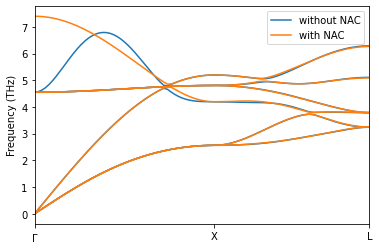

In [3]:
from phonopy.phonon.band_structure import get_band_qpoints_and_path_connections
from seekpath import get_path

# set up Phonopy object (initially without NAC)
ph = Phonopy(ase_to_phonopy(prim), cell_repetition)

# compile forces
natoms = ph.supercell.get_number_of_atoms()
forces = []
for k in range(1, 3):
    tag = f'{material}-n{natoms}-phonopy-{k:02d}-d{displ:.2f}'
    conf = db.get(filename=f'run_{tag}.xml.gz')
    forces.append(conf.forces)

# generate force constants
ph.generate_displacements(distance=displ)
ph.set_forces(forces)
ph.produce_force_constants()

# set up path through Brillouin zone using the seekpath package
seek_path = get_path((prim.cell, prim.get_scaled_positions(), prim.numbers))
labels = list(seek_path['point_coords'].keys())
labels = [lbl.replace('_2', '$_2$').replace('GAMMA', '$\\Gamma$') for lbl in labels]
path = [list(seek_path['point_coords'].values())]
qpoints, connections = get_band_qpoints_and_path_connections(path, npoints=51)

# compute band structure without NAC
ph.run_band_structure(qpoints, path_connections=connections, labels=labels)
band_wo_nac = ph.get_band_structure_dict()
lines = plt.plot(np.hstack(band_wo_nac['distances']), np.vstack(band_wo_nac['frequencies']), c='tab:blue', linestyle='-')
lines[-1].set_label('without NAC')

# add the NAC information to the Phonopy object, using the information from the database
# the factor of 14.4 is needed to convert from VASP to phonopy units
# see https://phonopy.github.io/phonopy/interfaces.html#default-unit-conversion-factor-for-non-analytical-term-correction
ph.nac_params = {'born': prim_row.data['born-effective-charges'],
                 'dielectric': prim_row.data['dielectric-tensor-electronic'],
                 'factor': 14.399652}

# repeat the generation of the force constants
ph.produce_force_constants()

# ... and the computation of the band structure
ph.run_band_structure(qpoints, path_connections=connections, labels=labels)
band_ref = ph.get_band_structure_dict()
lines = plt.plot(np.hstack(band_ref['distances']), np.vstack(band_ref['frequencies']), c='tab:orange', linestyle='-')
lines[-1].set_label('with NAC')

# annotate plot and show
qpt_coords = [0] + [seg[-1] for seg in band_ref['distances']]
plt.xticks(qpt_coords, labels=labels)
plt.xlim(qpt_coords[0], qpt_coords[2])
plt.ylabel('Frequency (THz)')
plt.legend()
plt.show()

From the dispersion plot it is apparent that in the absence of the NAC, there is no LO-TO splitting and the behavior of the LO branch along the $\Gamma$-X direction is wrong.

## Long-range corrections with hiphive

We will now use hiphive to analyze the force constants and the phonon dispersion of this system.
First, we construct a FCP using the same (systematically displaced) configurations as those used by phonopy above *without* accounting for the long range of the interactions, and evaluate the phonon dispersion

Then we repeat the exercise but rather than training against the actual forces, we first subtract the dipolar part of the interaction (using the dynamical matrix at $\vec{q}\rightarrow 0$ with the NAC).
We then compute the phonon dispersion using this "short-ranged" FCP (after adding back the long-range forces).

In [4]:
from hiphive import ClusterSpace, StructureContainer, ForceConstantPotential
from trainstation import Optimizer
from hiphive.utilities import get_displacements, prepare_structures

# set up cluster space
supercell = phonopy_to_ase(ph.supercell)
cutoff = 0.5 * np.linalg.norm(supercell.cell[0]) - 0.05
cs = ClusterSpace(prim, [cutoff])

# ... and structure container
sc = StructureContainer(cs)
structures = [row.toatoms() for row in db.select(material, natoms=natoms)
              if 'phonopy' in row.filename and f'd{displ:.2f}' in row.filename]
for structure in prepare_structures(structures, supercell):
    sc.add_structure(structure)
print(sc)

# train FCP without long-range corrections
opt = Optimizer(sc.get_fit_data())
opt.train()
print(opt)
fcp = ForceConstantPotential(cs, opt.parameters) 

# compute phonon dispersion
fc2 = fcp.get_force_constants(supercell).get_fc_array(order=2)
ph.set_force_constants(fc2)
ph.run_band_structure(qpoints, path_connections=connections, labels=labels)
band_nlrc = ph.get_band_structure_dict()

# compute long-range forces due to dipole interactions
ph.set_force_constants(np.zeros((len(supercell), len(supercell), 3, 3)))
dynmat = ph.get_dynamical_matrix()
dynmat.make_Gonze_nac_dataset()
fc_LR = -dynmat.get_Gonze_nac_dataset()[0]

# remove long-range forces from training data
displacements = np.array([s.displacements for s in sc])
M, F = sc.get_fit_data()
F -= np.einsum('ijab,njb->nia', -fc_LR, displacements).flatten()

# train FCP to remaining short-ranged forces
opt = Optimizer((M, F))
opt.train()
print(opt)
fcp = ForceConstantPotential(cs, opt.parameters) 

# add short and long-ranged contributions
fc2 = fcp.get_force_constants(supercell).get_fc_array(order=2)
ph.set_force_constants(fc2 + fc_LR)

# compute phonon dispersion
ph.run_band_structure(qpoints, path_connections=connections, labels=labels)
band_lrc = ph.get_band_structure_dict()

Primitive cell:
    Formula: ClNa
    Cell:
        [  0.00000   2.83250   2.83250]
        [  2.83250   0.00000   2.83250]
        [  2.83250   2.83250   0.00000]
    Basis:
        Na  [  0.00000   0.00000   0.00000]
        Cl  [  0.50000   0.50000   0.50000]

Crystal symmetry:
    Spacegroup:          Fm-3m (225)
    Unique site:         2
    Symmetry operations: 48
    symprec:             1.00e-05

Cutoffs:
    Maximum cutoff: 8.447499999999998
    Found 2 center atoms with 134 images totaling 136 atoms

Clusters:
    Clusters: {2: 185}
    Total number of clusters: 185

Orbits:
    Orbits: {2: 13}
    Total number of orbits: 13

Eigentensors:
    Eigentensors: {2: 35}
    Total number of parameters: 35

Constraints:
    Acoustic: True
    Number of degrees of freedom: {2: 33}
    Total number of degrees of freedom: 33
Done in 0d 0h 0m 7.15s
Done in 0d 0h 0m 3.02s
Done in 0d 0h 0m 0.0313s
=============== Structure Container ================
Total number of structures : 2
Number 

One notices that the root mean square error (RMSE) over the test set is smaller and the correlation coefficient $R^2$ increases if long-range interactions are treated separately.
More importantly when plotting the phonon dispersion, only the FCP with long-range corrections (LRC) properly reproduces the reference dispersion obtained using the conventional approach.

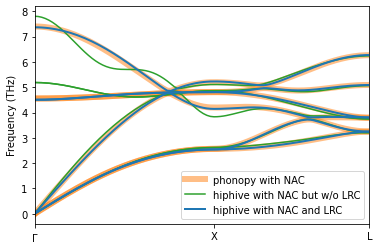

In [5]:
# plot phonopy result for reference
lines = plt.plot(np.hstack(band_ref['distances']), np.vstack(band_ref['frequencies']), c='tab:orange', linestyle='-', lw=6, alpha=0.5)
lines[-1].set_label('phonopy with NAC')

# hiphive FCP w/o LRC
lines = plt.plot(np.hstack(band_nlrc['distances']), np.vstack(band_nlrc['frequencies']), c='tab:green', linestyle='-')
lines[-1].set_label('hiphive with NAC but w/o LRC')

# hiphive FCP with LRC
lines = plt.plot(np.hstack(band_lrc['distances']), np.vstack(band_lrc['frequencies']), c='tab:blue', linestyle='-', lw=2)
lines[-1].set_label('hiphive with NAC and LRC')

# annotate plot and show
qpt_coords = [0] + [seg[-1] for seg in band_ref['distances']]
plt.xticks(qpt_coords, labels=labels)
plt.xlim(qpt_coords[0], qpt_coords[2])
plt.ylabel('Frequency (THz)')
plt.legend()
plt.show()

Finally, let us confirm that this approach also works when using rattled configurations.

In [6]:
# ... and structure container
sc = StructureContainer(cs)
structures = [db.get(filename=f'run_{material}-n{natoms}-rattled-01-d0.01.xml.gz').toatoms()]
for structure in prepare_structures(structures, supercell):
    sc.add_structure(structure)
print(sc)

# remove long-range forces from training data
displacements = np.array([s.displacements for s in sc])
M, F = sc.get_fit_data()
F -= np.einsum('ijab,njb->nia', -fc_LR, displacements).flatten()

# train FCP to remaining short-ranged forces
opt = Optimizer((M, F))
opt.train()
print(opt)
fcp = ForceConstantPotential(cs, opt.parameters) 

# add short and long-ranged contributions
fc2 = fcp.get_force_constants(supercell).get_fc_array(order=2)
ph.set_force_constants(fc2 + fc_LR)

# compute phonon dispersion
ph.run_band_structure(qpoints, path_connections=connections, labels=labels)
band_lrc_rattled = ph.get_band_structure_dict()

Done in 0d 0h 0m 7.33s
Done in 0d 0h 0m 0.032s
=============== Structure Container ================
Total number of structures : 1
Number of force components : 648
----------------------------------------------------
index | num-atoms | avg-disp | avg-force | max-force
----------------------------------------------------
 0    |    216    |  0.0157  |   0.0389  |   0.1000 
===================== Optimizer ======================
seed                           : 42
fit_method                     : least-squares
standardize                    : True
n_target_values                : 648
n_parameters                   : 33
n_nonzero_parameters           : 33
parameters_norm                : 0.276393
target_values_std              : 0.02443942
rmse_train                     : 0.0006111273
rmse_test                      : 0.0008222842
R2_train                       : 0.999364
R2_test                        : 0.9990133
AIC                            : -8562.639
BIC                            : 

In [7]:
lines = plt.plot(np.hstack(band_lrc['distances']), np.vstack(band_lrc['frequencies']), c='tab:orange', linestyle='-', lw=6, alpha=0.5)
lines[-1].set_label('hiphive using 2 enumerated structures')

lines = plt.plot(np.hstack(band_lrc_rattled['distances']), np.vstack(band_lrc_rattled['frequencies']), c='tab:blue', linestyle='-', lw=2)
lines[-1].set_label('hiphive using 1 rattled structure')

# annotate plot and show
qpt_coords = [0] + [seg[-1] for seg in band_ref['distances']]
plt.xticks(qpt_coords, labels=labels)
plt.xlim(qpt_coords[0], qpt_coords[2])
plt.ylabel('Frequency (THz)')
plt.legend()
plt.show()